# Get Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [2]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0 nilearn==0.10.0
!pip install kds

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 76.4 MB/s eta 0:00:00:00:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 79.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
  Attempting uninstall: nilearn
    Found existing installation: nilearn 0.11.1
    Uninstalling nilearn-0.11.1:
      Successfully uninstalled nilearn-0.11.1
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12

In [3]:
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, StratifiedKFold, cross_validate
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from scipy.stats import zscore
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import GradientBoostingClassifier
import shap
import kds
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, recall_score, roc_auc_score, precision_score, accuracy_score

In [4]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)
pd.set_option('future.no_silent_downcasting', True)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [24]:
df = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
df_s = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [6]:
df_test = pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')

In [15]:
df.shape, df_s.shape

((590540, 394), (144233, 41))

In [ ]:
df['isFraud'].value_counts(normalize=True) * 100

In [13]:
df.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,M1,M2,M3,M4,M5,M6,M7,M8,M9,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,V41,V42,V43,V44,V45,V46,V47,V48,V49,V50,V51,V52,V53,V54,V55,V56,V57,V58,V59,V60,V61,V62,V63,V64,V65,V66,V67,V68,V69,V70,V71,V72,V73,V74,V75,V76,V77,V78,V79,V80,V81,V82,V83,V84,V85,V86,V87,V88,V89,V90,V91,V92,V93,V94,V95,V96,V97,V98,V99,V100,V101,V102,V103,V104,V105,V106,V107,V108,V109,V110,V111,V112,V113,V114,V115,V116,V117,V118,V119,V120,V121,V122,V123,V124,V125,V126,V127,V128,V129,V130,V131,V132,V133,V134,V135,V136,V137,V138,V139,V140,V141,V142,V143,V144,V145,V146,V147,V148,V149,V150,V151,V152,V153,V154,V155,V156,V157,V158,V159,V160,V161,V162,V163,V164,V165,V166,V167,V168,V169,V170,V171,V172,V173,V174,V175,V176,V177,V178,V179,V180,V181,V182,V183,V184,V185,V186,V187,V188,V189,V190,V191,V192,V193,V194,V195,V196,V197,V198,V199,V200,V201,V202,V203,V204,V205,V206,V207,V208,V209,V210,V211,V212,V213,V214,V215,V216,V217,V218,V219,V220,V221,V222,V223,V224,V225,V226,V227,V228,V229,V230,V231,V232,V233,V234,V235,V236,V237,V238,V239,V240,V241,V242,V243,V244,V245,V246,V247,V248,V249,V250,V251,V252,V253,V254,V255,V256,V257,V258,V259,V260,V261,V262,V263,V264,V265,V266,V267,V268,V269,V270,V271,V272,V273,V274,V275,V276,V277,V278,V279,V280,V281,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,13.0,NaN,NaN,NaN,0.0,T,T,T,M2,F,T,NaN,NaN,NaN,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [14]:
df_s.head(10)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS
5,2987017,-5.0,61141.0,3.0,0.0,3.0,0.0,NaN,NaN,3.0,0.0,100.0,NotFound,52.0,-300.0,Found,Found,166.0,18.0,529.0,600.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Windows 10,chrome 62.0,24.0,1366x768,match_status:2,T,F,T,T,desktop,Windows
6,2987022,-15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NotFound,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987038,0.0,31964.0,0.0,0.0,0.0,-10.0,NaN,NaN,0.0,0.0,100.0,Found,NaN,-300.0,Found,Found,166.0,15.0,352.0,533.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Android,chrome 62.0,32.0,1920x1080,match_status:2,T,F,T,T,mobile,NaN
8,2987040,-10.0,116098.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
9,2987048,-5.0,257037.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,484.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows


In [ ]:
df.isna().sum()

In [ ]:
num_duplicates = df_s.duplicated(subset='TransactionID').sum()
print(f"Number of duplicate TransactionIDs: {num_duplicates}")

In [ ]:
df['isFraud'].value_counts()

# Cleaning

In [18]:
def get_cat_cols(df):
    return df.select_dtypes(include=['object', 'category']).columns

def get_num_cols(df):
    return df.select_dtypes(include=['int64','float64', 'number']).columns

In [ ]:
cols_to_remove=df.columns[df.isna().mean() > 0.7]
row_nan_frac=0.5
num_imputer=SimpleImputer(strategy='mean')
cat_imputer=SimpleImputer(strategy='most_frequent')
outlier_handling='iqr'
outlier_thresh=0.1

In [19]:
def clean(df,
          cols_to_remove=df.columns[df.isna().mean() > 0.7],
          row_nan_frac=0.5,
          outlier_handling='none',
          outlier_thresh=0.25):
    # drop useless cols
    df_pre = df.drop(columns=cols_to_remove, errors='ignore')

    # drop useless rows
    df_pre.dropna(axis=0, thresh=int(df_pre.shape[1] * (1 - row_nan_frac)), inplace=True)

    # remove outliers
    majority = df_pre[df_pre['isFraud'] == 0]
    minority = df_pre[df_pre['isFraud'] == 1]
    if outlier_handling == 'zscore':
        z_scores = np.abs(zscore(majority[num_cols]))
        majority = majority[(z_scores < outlier_thresh).all(axis=1)]
    elif outlier_handling == 'iqr':
        Q1 = majority[num_cols].quantile(outlier_thresh)
        Q3 = majority[num_cols].quantile(1 - outlier_thresh)
        IQR = Q3 - Q1

        majority = majority[~((majority[num_cols] < (Q1 - 1.5 * IQR)) | (majority[num_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]

    df_pre = pd.concat([majority, minority])
    
    return df_pre

In [ ]:
df_cleaned = clean(df, outlier_handling=outlier_handling, outlier_thresh=outlier_thresh)
df_cleaned.head(10)

In [ ]:
df_cleaned.shape

In [ ]:
df_cleaned['isFraud'].value_counts()

In [ ]:
X = df_cleaned.drop(columns=['isFraud'])
X.head(10)

In [ ]:
y = df_cleaned['isFraud']
y.head(10)

In [20]:
class CleaningPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 cols_to_remove=[]):
        self.cols_to_remove = cols_to_remove
    
    def fit(self, X, y=None):
        X_clean = X.drop(columns=self.cols_to_remove, errors='ignore')
        return self
    
    def transform(self, X):
        
        X_clean = X.copy()

        # drop useless cols
        X_clean.drop(columns=self.cols_to_remove, errors='ignore', inplace=True)
        
        return X_clean

In [ ]:
cleaner = CleaningPreprocessor(cols_to_remove=cols_to_remove)

In [ ]:
cleaned = cleaner.fit_transform(X, y)
cleaned.shape

In [ ]:
cleaned_test = cleaner.transform(df_test)
cleaned_test.shape

In [ ]:
cleaned.head(10)

In [ ]:
cleaned.dtypes

In [ ]:
cleaned_test.isna().sum()

# Feature Engineering

In [21]:
class FeatureEngineeringPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, encoding):
        self.encoding = encoding
    
    def fit(self, X, y):
        x_tmp = pd.concat([X, y], axis=1)
        self.cat_cols = get_cat_cols(X)
        if self.encoding == 'target':
            self.target_mean_map = {}
            for col in self.cat_cols:
                self.target_mean_map[col] = x_tmp.groupby(col)[y.name].mean()
        elif self.encoding == 'frequency':
            self.frequency_map = {}
            for col in self.cat_cols:
                self.frequency_map[col] = X[col].value_counts(normalize=True)
        elif self.encoding == 'woe':
            self.woe_map = {}
            for col in self.cat_cols:
                groups = x_tmp.groupby([col])['isFraud'].agg(['count', 'sum'])
                groups.columns = ['n_obs', 'n_pos']
                groups['n_neg'] = groups['n_obs'] - groups['n_pos']
        
                groups['prop_pos'] = groups['n_pos'] / groups['n_pos'].sum()
                groups['prop_neg'] = groups['n_neg'] / groups['n_neg'].sum()

                epsilon = 1e-6
                groups['woe'] = np.log(groups['prop_pos']+epsilon/ groups['prop_neg']+epsilon)
        
                groups.replace([np.inf, -np.inf], 0, inplace=True)
                groups.fillna(0, inplace=True)
            
                woe_dict = groups['woe'].to_dict()
            
                self.woe_map[col] = woe_dict
        return self
    
    def transform(self, X):
        modified = set()
        X_transformed = X.copy()
        
        if self.encoding == 'one_hot':
            one_hot_encoded = X_transformed = pd.get_dummies(X_transformed, columns=self.cat_cols, drop_first=True)
        elif self.encoding == 'target':
            for col in self.cat_cols:
                X_transformed[col] = X_transformed[col].map(self.target_mean_map[col])
        elif self.encoding == 'frequency':
            for col in self.cat_cols:
                X_transformed[col] = X_transformed[col].map(self.frequency_map[col])
        elif self.encoding == 'woe':
            for col in self.cat_cols:
                X_transformed[col] = X_transformed[col].map(self.woe_map[col])
        else:
            encoder = LabelEncoder()
            for col in self.cat_cols:
                X_transformed[col] = encoder.fit_transform(X_transformed[col])

        return X_transformed

In [ ]:
cleaned_cat_cols = get_cat_cols(cleaned)
cleaned_cat_cols

In [ ]:
engineer = FeatureEngineeringPreprocessor(woe_cats=cleaned_cat_cols)

In [ ]:
engineered = engineer.fit_transform(cleaned, y)
engineered.head(10)

In [ ]:
engineered_test = engineer.transform(cleaned_test)
engineered_test.head(10)

# Feature Selection

In [22]:
def correlation_filter(X, y, threshold=0.8, log=False):
    corr = X.drop(columns=['TransactionID']).corr().abs()

    to_drop_pairs = []
    for i in range(len(corr.columns)):
        for j in range(i):
            if corr.iloc[i, j] > threshold:
                to_drop_pairs.append((corr.columns[i], corr.columns[j], corr.iloc[i, j]))

    if log:
        print("Highly correlated pairs:")
        for col1, col2, corr_val in to_drop_pairs:
            print(f"{col1} and {col2}: {corr_val}")
        
    to_drop = set()
    for col1, col2, _ in to_drop_pairs:
        if abs(X[col1].corr(y)) > abs(X[col2].corr(y)):
            to_drop.add(col2)
        else:
            to_drop.add(col1)
            
    to_drop = list(to_drop)
    if log:
        print(f"Columns to drop: {to_drop}")
    
    return to_drop


def rfe_feature_selection(X, y, model, n_features_to_select=30, log=False):
    # Drop 'TransactionID' if present
    X_t = X.drop(columns=['TransactionID'], errors='ignore')
    
    # Initialize and fit RFE
    selector = RFE(model, n_features_to_select=n_features_to_select, step=1)
    selector.fit(X_t, y)
    
    # Create DataFrame of selected features
    selected_df = pd.DataFrame({
        'feature': X_t.columns,
        'selected': selector.support_,
        'ranking': selector.ranking_
    }).sort_values(by='selected', ascending=False).reset_index(drop=True)
    
    if log:
        selected_list = selected_df[selected_df['selected']]['feature'].tolist()
        print(f"Selected features: {selected_list}")
    
    return selected_df


def shap_feature_importance(model, X):
    # Initialize SHAP explainer (TreeExplainer for tree-based models)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    
    # Calculate mean absolute SHAP value per feature
    shap_importance = np.abs(shap_values).mean(axis=0)
    
    # Create DataFrame with feature importances
    shap_df = pd.DataFrame({
        'feature': X.columns,
        'importance': shap_importance
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    return shap_df


def model_feature_importance(model, X):
    # Extract feature importances from the model
    importances = model.feature_importances_
    
    # Create DataFrame with feature importances
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).reset_index(drop=True)
    
    return importance_df


In [23]:
class FeatureSelectionPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, selected_features=None):
        self.selected_features = selected_features
    
    def fit(self, X, y):
        return self
    
    def transform(self, X):
        X_transformed = X.copy()
        if self.selected_features is not None:
            for col in self.selected_features:
                if col not in X_transformed.columns:
                    X_transformed[col] = False
            return X_transformed[self.selected_features]
        return X_transformed

In [ ]:
to_drop_corr = correlation_filter(engineered, y, log=True)
dropped_corr = engineered.drop(columns=to_drop_corr)
to_stay_rfe = rfe(dropped_corr, y, log=True)

In [ ]:
selector = FeatureSelectionPreprocessor(selected_features=to_stay_rfe)

In [ ]:
selected = selector.fit_transform(engineered, y)
selected.head(10)

# Training

In [25]:
# cleaning

cols_to_remove=df.columns[df.isna().mean() > 0.5]
row_nan_frac=0.5
outlier_handling='none'
outlier_thresh=0.1

df_cleaned = clean(df, 
                   cols_to_remove=cols_to_remove, 
                   row_nan_frac=row_nan_frac,
                   outlier_handling=outlier_handling, 
                   outlier_thresh=outlier_thresh)
X = df_cleaned.drop(columns=['isFraud'])
y = df_cleaned['isFraud']
cleaner = CleaningPreprocessor(cols_to_remove=cols_to_remove)
cleaned = cleaner.fit_transform(X, y)
print('cleaned')

cleaned


In [27]:
cleaned.shape

(590484, 219)

In [ ]:
y.value_counts()

In [ ]:
cleaned.isna().sum()

In [28]:
# engineering

encoding='woe'
engineer = FeatureEngineeringPreprocessor(encoding=encoding)
engineered = engineer.fit_transform(X, y)
print('engineered')

engineered


In [ ]:
engineered.isna().sum()

In [29]:
# selecting

corr_threshold = 0.8

to_drop_corr = correlation_filter(engineered, y, threshold=corr_threshold, log=True)
selected = engineered.drop(columns=to_drop_corr)
print('selected (dropped)')

Highly correlated pairs:
C2 and C1: 0.9950922265975789
C4 and C1: 0.9678191450801629
C4 and C2: 0.9721683685989218
C6 and C1: 0.9822644098898683
C6 and C2: 0.9748799452962646
C6 and C4: 0.9622870266344012
C7 and C1: 0.926453560690114
C7 and C2: 0.9390523410888787
C7 and C4: 0.8954804876796856
C7 and C6: 0.8589508876210122
C8 and C1: 0.9677808071033681
C8 and C2: 0.9758976622250058
C8 and C4: 0.9601410514138992
C8 and C6: 0.9220955042337347
C8 and C7: 0.9830458297299794
C9 and C5: 0.9257855428353142
C10 and C1: 0.9582434265005132
C10 and C2: 0.9706624494762316
C10 and C4: 0.9526259389876505
C10 and C6: 0.9145783408945913
C10 and C7: 0.9851145588877714
C10 and C8: 0.9969706004899238
C11 and C1: 0.996517355975288
C11 and C2: 0.9939048166706655
C11 and C4: 0.9745470557188236
C11 and C6: 0.9911159410470871
C11 and C7: 0.9154598146020854
C11 and C8: 0.962783340926507
C11 and C10: 0.9561266792835369
C12 and C1: 0.9281356723190011
C12 and C2: 0.9404422762462694
C12 and C4: 0.8950068199397686
C

In [ ]:
selected = engineered.drop(columns=to_drop_corr)

In [ ]:
# feature importance
ranked_features_df = model_feature_importance(model, sampled)

In [33]:
# shap
ranked_features_df = shap_feature_importance(model, sampled)

In [ ]:
ranked_features_df.head(10)

In [34]:
# selecting (feature importance or shap)
n_features_to_select = 30
to_stay = ranked_features_df[:n_features_to_select]['feature']

selector = FeatureSelectionPreprocessor(selected_features=to_stay)
selected = selector.fit_transform(engineered, y)
print('selected')

selected


In [ ]:
to_stay

In [ ]:
# sampling

sampler = SMOTE(random_state=42)
sampled, sampled_y = sampler.fit_resample(selected, y)
print('sampled')
sampled.head(10)

In [35]:
# no sampling

sampler = None
sampled = selected
sampled_y = y
print('not sampled')

not sampled


In [31]:
!pip install xgboost

In [74]:
# model
from xgboost import XGBClassifier


# Compute class imbalance ratio
scale = len(sampled_y[sampled_y == 0]) / len(sampled_y[sampled_y == 1])

model = XGBClassifier(
    # Core parameters
    n_estimators=300,              # Number of boosting rounds (more = more complex)
    learning_rate=1.0,             # Smaller = slower but often better
    max_depth=4,                   # Controls tree complexity
    subsample=0.8,                 # Fraction of rows used per tree
    colsample_bytree=0.8,          # Fraction of features used per tree
    gamma=1,                     # Minimum loss reduction required to make a split (regularization)
    
    # Regularization
    reg_alpha=0.1,                 # L1 regularization term
    reg_lambda=1.0,                # L2 regularization term

    # Class imbalance
    scale_pos_weight=scale,        # Helps balance classes during training

    # Misc
    min_child_weight=10,           # Minimum sum of instance weights needed in a child
    max_delta_step=1,              # Helps in logistic regression with imbalanced classes
    objective='binary:logistic',   # Output probabilities for binary classification
    use_label_encoder=False,       # Needed for newer versions of xgboost
    eval_metric='auc',             # Better metric for imbalanced data
    random_state=42,
    verbosity=1
)

modeled = model.fit(sampled, sampled_y)
print('modeled')

modeled


## Evaluate

In [75]:
full_pipe = ImbPipeline([
    ('cleaner', cleaner),
    ('engineer', engineer),
    ('selector', selector),
    ('sampler', sampler),
    ('model', model)
])

skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

scoring = {
    'f1_macro': 'f1_macro',
    'recall_macro': 'recall_macro',
    'roc_auc': 'roc_auc',
    'precision_macro': 'precision_macro',
    'accuracy': 'accuracy'
}

In [76]:
def evaluate_model(full_pipe, X, y, cv=3):
    # Stratified K-fold
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    
    # Initialize variables to store results
    train_f1_scores = []
    train_recall_scores = []
    train_roc_auc_scores = []
    train_precision_scores = []
    train_accuracy_scores = []
    
    test_f1_scores = []
    test_recall_scores = []
    test_roc_auc_scores = []
    test_precision_scores = []
    test_accuracy_scores = []
    
    y_true_all = []
    y_pred_all = []
    y_proba_all = []

    # Loop over each fold
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model on the training data
        full_pipe.fit(X_train, y_train)
        
        # Predict on the test set
        y_pred_test = full_pipe.predict(X_test)
        y_proba_test = full_pipe.predict_proba(X_test)[:, 1]  # Probability for class 1
        
        # Predict on the training set
        y_pred_train = full_pipe.predict(X_train)
        y_proba_train = full_pipe.predict_proba(X_train)[:, 1]  # Probability for class 1

        # Collect true values, predictions, and probabilities
        y_true_all.extend(y_test)
        y_pred_all.extend(y_pred_test)
        y_proba_all.extend(y_proba_test)

        # Calculate the evaluation metrics for this fold on the test set
        f1_test = f1_score(y_test, y_pred_test, average='macro')
        recall_test = recall_score(y_test, y_pred_test, average='macro')
        roc_auc_test = roc_auc_score(y_test, y_proba_test)
        precision_test = precision_score(y_test, y_pred_test, average='macro')
        accuracy_test = accuracy_score(y_test, y_pred_test)

        # Calculate the evaluation metrics for this fold on the training set
        f1_train = f1_score(y_train, y_pred_train, average='macro')
        recall_train = recall_score(y_train, y_pred_train, average='macro')
        roc_auc_train = roc_auc_score(y_train, y_proba_train)
        precision_train = precision_score(y_train, y_pred_train, average='macro')
        accuracy_train = accuracy_score(y_train, y_pred_train)

        # Store the results
        train_f1_scores.append(f1_train)
        train_recall_scores.append(recall_train)
        train_roc_auc_scores.append(roc_auc_train)
        train_precision_scores.append(precision_train)
        train_accuracy_scores.append(accuracy_train)

        test_f1_scores.append(f1_test)
        test_recall_scores.append(recall_test)
        test_roc_auc_scores.append(roc_auc_test)
        test_precision_scores.append(precision_test)
        test_accuracy_scores.append(accuracy_test)

    # Print cross-validation scores for training
    print("Training Scores:")
    print(f"F1 Macro: {np.mean(train_f1_scores):.4f}")
    print(f"Recall Macro: {np.mean(train_recall_scores):.4f}")
    print(f"ROC AUC: {np.mean(train_roc_auc_scores):.4f}")
    print(f"Precision Macro: {np.mean(train_precision_scores):.4f}")
    print(f"Accuracy: {np.mean(train_accuracy_scores):.4f}")
    
    # Print cross-validation scores for testing
    print("\nTesting Scores:")
    print(f"F1 Macro: {np.mean(test_f1_scores):.4f}")
    print(f"Recall Macro: {np.mean(test_recall_scores):.4f}")
    print(f"ROC AUC: {np.mean(test_roc_auc_scores):.4f}")
    print(f"Precision Macro: {np.mean(test_precision_scores):.4f}")
    print(f"Accuracy: {np.mean(test_accuracy_scores):.4f}")

    # Return scores as a dictionary
    scores_map = {
        'train_f1_macro': np.mean(train_f1_scores),
        'train_recall_macro': np.mean(train_recall_scores),
        'train_roc_auc': np.mean(train_roc_auc_scores),
        'train_precision_macro': np.mean(train_precision_scores),
        'train_accuracy': np.mean(train_accuracy_scores),
        
        'test_f1_macro': np.mean(test_f1_scores),
        'test_recall_macro': np.mean(test_recall_scores),
        'test_roc_auc': np.mean(test_roc_auc_scores),
        'test_precision_macro': np.mean(test_precision_scores),
        'test_accuracy': np.mean(test_accuracy_scores)
    }
    
    return y_true_all, y_pred_all, y_proba_all, scores_map

In [77]:
y_true_all, y_pred_all, y_proba_all, scores = evaluate_model(full_pipe, X, y, cv=3)

Training Scores:
F1 Macro: 0.6933
Recall Macro: 0.9240
ROC AUC: 0.9773
Precision Macro: 0.6395
Accuracy: 0.9144

Testing Scores:
F1 Macro: 0.6589
Recall Macro: 0.8509
ROC AUC: 0.9265
Precision Macro: 0.6162
Accuracy: 0.9052


# Graphs

In [78]:
def tree_vis(model, cols):
    plt.figure(figsize=(16, 6))
    plot_tree(model, feature_names=cols, filled=True, rounded=True, max_depth=4)
    plt.title("Decision Tree Visualization")
    plt.savefig("decision_tree.png", dpi=300, bbox_inches='tight')
    plt.show()

def feat_imp(modeled, cols):
    importances = modeled.feature_importances_

    feature_names = cols

    feat_imp_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    top_features = feat_imp_df['Feature'].tolist()

    plt.figure(figsize=(10, 6))
    plt.barh(feat_imp_df['Feature'][:20][::-1], feat_imp_df['Importance'][:20][::-1])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances (Decision Tree)')
    plt.tight_layout()
    plt.savefig("top_20_feature_importances.png", dpi=300, bbox_inches='tight')
    plt.show()

def shap_g(model, selected):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(selected)
    shap.summary_plot(shap_values, selected, show=False)
    plt.gcf().tight_layout()  # Clean layout
    plt.savefig("shap_summary_plot.png", dpi=300, bbox_inches='tight')  # Save
    plt.show()  # Now display the plot
    plt.close()  # Close after display

def conf_mat(y_true_all, y_pred_all, labels=None):
    cm = confusion_matrix(y_true_all, y_pred_all, labels=labels)

    print("\nConfusion Matrix:")
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.savefig("confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()

def roc(y_true_all, y_proba_all):
    fpr, tpr, _ = roc_curve(y_true_all, y_proba_all)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.savefig("roc.png", dpi=300, bbox_inches='tight')
    plt.show()

def prec_rec(y_true_all, y_proba_all):
    precision, recall, _ = precision_recall_curve(y_true_all, y_proba_all)
    avg_precision = average_precision_score(y_true_all, y_proba_all)
    print(f"Average Precision: {avg_precision:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(recall, precision, color='b', label=f'Precision-Recall curve (AP = {avg_precision:.4f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.savefig("precision_recall_plot.png", dpi=300, bbox_inches='tight')
    plt.show()

In [79]:
tree_vis(model, X.columns)

InvalidParameterError: The 'decision_tree' parameter of plot_tree must be an instance of 'sklearn.tree._classes.DecisionTreeClassifier' or an instance of 'sklearn.tree._classes.DecisionTreeRegressor'. Got XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=1.0, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=4, max_leaves=None, min_child_weight=10, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...) instead.

<Figure size 1600x600 with 0 Axes>

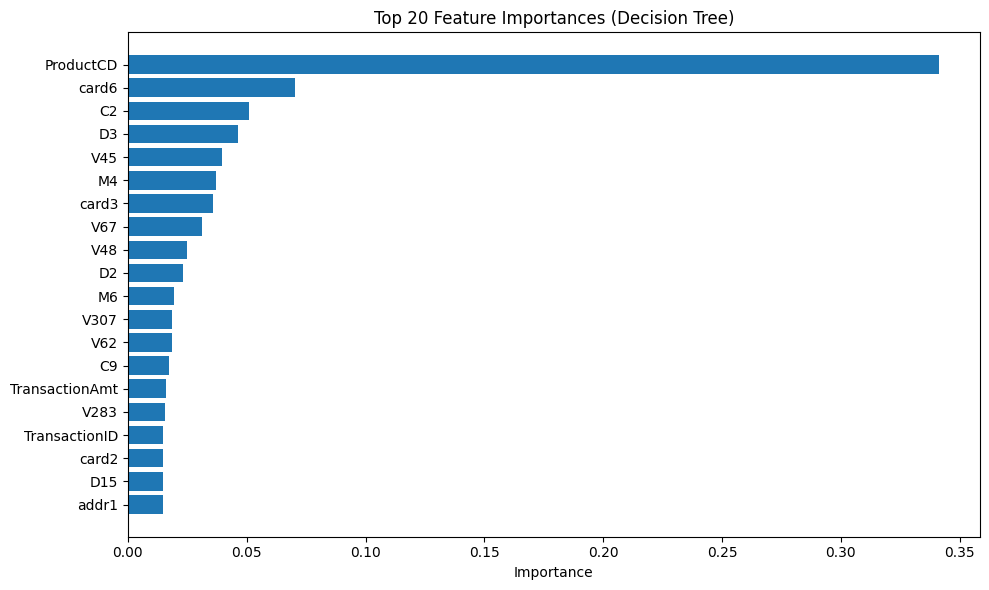

In [80]:
feat_imp(modeled, selected.columns)

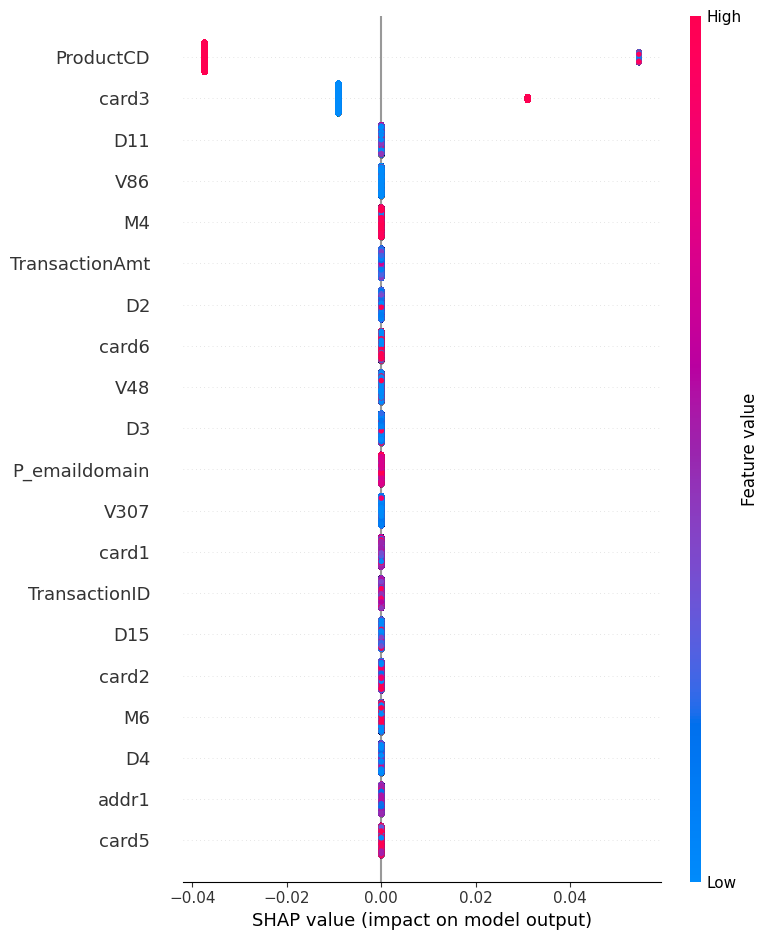

In [67]:
shap_g(model, selected)


Confusion Matrix:


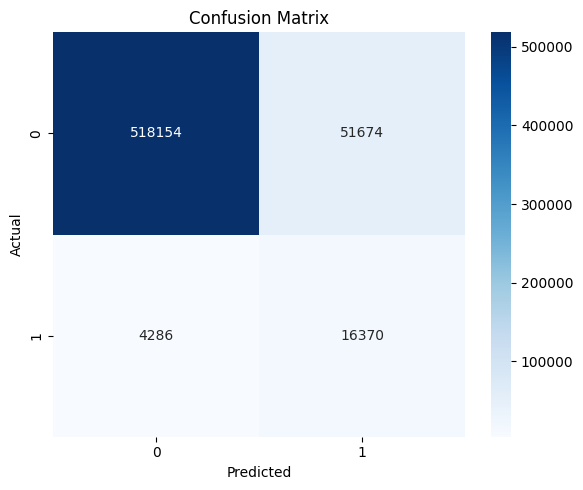

In [81]:
conf_mat(y_true_all, y_pred_all)

ROC AUC: 0.9265


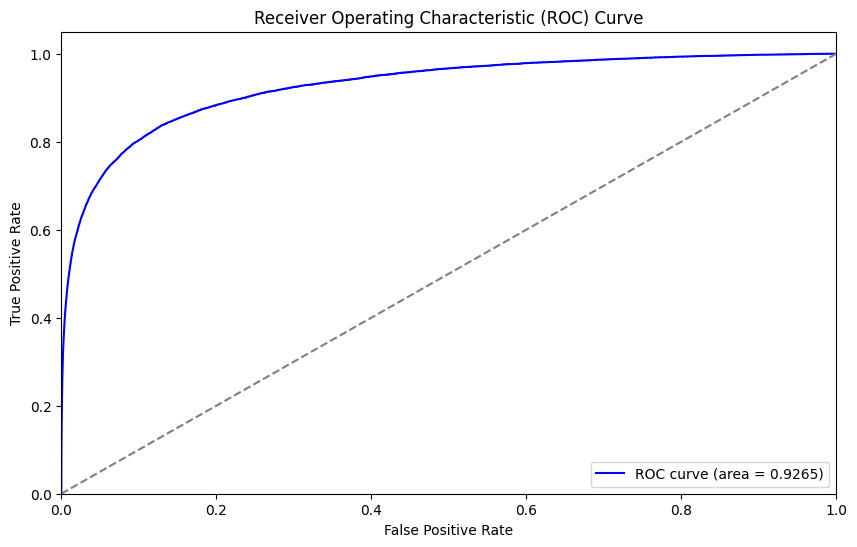

In [82]:
roc(y_true_all, y_proba_all)

Average Precision: 0.5854


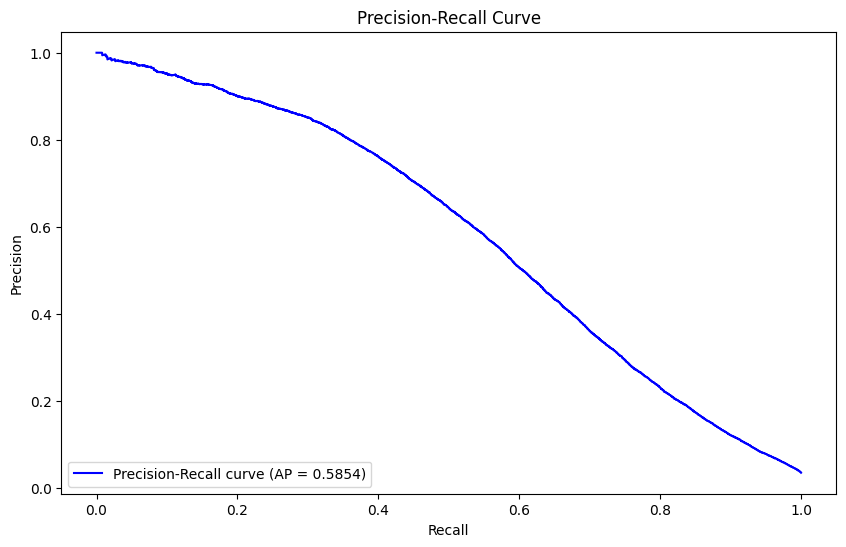

In [83]:
prec_rec(y_true_all, y_proba_all)

# Random Search

In [40]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.model_selection import train_test_split

def randfloat(low, high):
    return uniform(loc=low, scale=high - low)

X_small, _, y_small, _ = train_test_split(
    X, y,
    test_size=0.5,         
    stratify=y,            # keeps class distribution
    random_state=42        # reproducibility
)

# Define parameter distributions
param_distributions = {
    'model__max_depth': randint(2, 5),
    'model__n_estimators': randint(100, 300),
    'model__learning_rate': randfloat(0.05, 0.12),
    'model__gamma': randfloat(1.0, 3.0)
}

# Set up randomized search
random_search = RandomizedSearchCV(
    estimator=full_pipe,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='roc_auc',
    cv=skf,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    return_train_score=True
)

# Run it
random_search.fit(X_small, y_small)

# Best results
print("Best parameters found:")
print(random_search.best_params_)

print("\nBest score:")
print(random_search.best_score_)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'model__gamma': 2.8533177315875884, 'model__learning_rate': 0.10090903970994947, 'model__max_depth': 4, 'model__n_estimators': 299}

Best score:
0.9072613880845477


In [41]:
# Create DataFrame from search results
results_df = pd.DataFrame(random_search.cv_results_)

# Drop split-specific columns
results_df = results_df.drop(columns=[col for col in results_df.columns if col.startswith('split')])

# Sort by rank of f1_macro score
results_df = results_df.sort_values(by='rank_test_score')

results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__gamma,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,params,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
16,17.268505,0.275831,2.001813,0.049963,2.853318,0.100909,4,299,"{'model__gamma': 2.8533177315875884, 'model__l...",0.907261,0.001299,1,0.935272,0.000781
0,13.143295,0.248423,2.248080,0.263943,1.74908,0.11655,4,171,"{'model__gamma': 1.749080237694725, 'model__le...",0.900335,0.000988,2,0.921856,0.000713
2,15.678703,0.242046,2.157919,0.188276,1.918498,0.07336,4,249,"{'model__gamma': 1.9184977839317343, 'model__l...",0.899521,0.000957,3,0.919873,0.000882
11,17.443781,0.625018,2.007756,0.269476,1.461788,0.066872,4,271,"{'model__gamma': 1.461787651244298, 'model__le...",0.899302,0.001193,4,0.919663,0.000531
6,17.610154,0.226059,2.235721,0.197931,1.799722,0.053267,4,289,"{'model__gamma': 1.799721943430511, 'model__le...",0.896622,0.001378,5,0.914243,0.000349
18,11.412407,0.466951,1.688795,0.044365,2.689068,0.102312,4,152,"{'model__gamma': 2.689067697356303, 'model__le...",0.895940,0.001553,6,0.914166,0.000967
7,11.339994,0.208189,1.784867,0.040230,1.181213,0.093287,4,163,"{'model__gamma': 1.1812128690656416, 'model__l...",0.895857,0.001478,7,0.913792,0.000904
8,10.011947,0.374729,1.660522,0.196709,1.933526,0.110196,4,120,"{'model__gamma': 1.9335257864959599, 'model__l...",0.893342,0.001329,8,0.909620,0.000408
15,15.116185,0.400681,1.822515,0.226939,2.68457,0.081483,3,289,"{'model__gamma': 2.6845695491899972, 'model__l...",0.890709,0.001098,9,0.904814,0.000994
1,12.643087,0.544277,1.725183,0.302021,2.197317,0.060921,4,174,"{'model__gamma': 2.197316968394073, 'model__le...",0.889633,0.001665,10,0.903417,0.000928


# Dagshub Upload

In [49]:
!pip install dagshub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 4.9 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 2.9 MB/s eta 0:00:00
  Attempting uninstall: dacite
    Found existing installation: dacite 1.9.2
    Uninstalling dacite-1.9.2:
      Successfully uninstalled dacite-1.9.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.16.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.


In [50]:
import dagshub
dagshub.init(repo_owner='Cimbir', repo_name='IEEE-CIS_Fraud_Detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=56bcad2b-1700-4e92-8b92-604dcbf7f0ba&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=11940c8d3de4dfc2435e207e4ecb09363429864932d8569d309ef717ab1f3e9b




Accessing as Cimbir

Initialized MLflow to track repo "Cimbir/IEEE-CIS_Fraud_Detection"

Repository Cimbir/IEEE-CIS_Fraud_Detection initialized!

In [51]:
!pip install mlflow==2.10.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 63.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 27.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 13.3 MB/s eta 0:00:00:00:01
  Attempting uninstall: pytz
    Found existing installation: pytz 2025.2
    Uninstalling pytz-2025.2:
      Successfully uninstalled pytz-2025.2
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib_metadata 8.6.1
    Uninstalling importlib_metadata-8.6.1:
      Successfully uninstalled importlib_metadata-8.6.1
  Attempting uninstall: pyarrow
    Found existing installation: pyar

In [84]:
import mlflow

mlflow.set_experiment(f'XGBoost_Training')

i = 'Overfit'

# with mlflow.start_run(run_name=f'XGBoost_Cleaning_{i}') as run:
#     mlflow.log_param('cols_to_remove', cols_to_remove)
#     mlflow.log_param('row_nan_frac', row_nan_frac)
#     mlflow.log_param('outlier_handling', outlier_handling)
#     mlflow.log_param('outlier_thresh', outlier_thresh)

# with mlflow.start_run(run_name=f'XGBoost_Engineering_{i}') as run:
#     mlflow.log_param('encoding', encoding)
    
# with mlflow.start_run(run_name=f'XGBoost_Selection_{i}') as run:
#     mlflow.log_param('corr_threshold', corr_threshold)
#     mlflow.log_param('n_features_to_select', n_features_to_select)
#     mlflow.log_param('to_stay', to_stay)
#     mlflow.log_param('feature_selection_method', 'shap')
    
with mlflow.start_run(run_name=f'XGBoost_Model_{i}') as run:
    mlflow.log_param('sampler', sampler)
    mlflow.log_param('model', model)

    for key, value in scores.items():
        mlflow.log_metric(key, value.mean())

    for param_name, param_value in model.get_params().items():
        mlflow.log_param('best_'+param_name, param_value)

    # mlflow.log_param('model__max_depth', '2-5')
    # mlflow.log_param('model__n_estimators', '100-300')
    # mlflow.log_param('model__learning_rate', '0.05-0.12')
    # mlflow.log_param('model__gamma', '1.0-3.0')

    mlflow.log_artifact("confusion_matrix.png", artifact_path='graph')
    # mlflow.log_artifact("decision_tree.png", artifact_path='graph')
    mlflow.log_artifact("top_20_feature_importances.png", artifact_path='graph')
    # mlflow.log_artifact("shap_summary_plot.png", artifact_path='graph')
    mlflow.log_artifact("roc.png", artifact_path='graph')
    mlflow.log_artifact("precision_recall_plot.png", artifact_path='graph')

    # mlflow.sklearn.log_model(full_pipe, artifact_path='model')
    # mlflow.sklearn.log_model(full_pipe, artifact_path='model', registered_model_name=f'xgboost_search_best')

    # results_df.to_csv('search_results.csv')
    # mlflow.log_artifact('search_results.csv', artifact_path='search')
    

In [ ]:
# Replace with your actual run ID
run_id = "3dc48e07ef934562a6b2d8f18eb1ca7f"

# Start a context to log into the existing run
with mlflow.start_run(run_id=run_id):
   mlflow.log_artifact("shap_summary_plot.png", artifact_path='graph')